In [118]:
"""
A script/notebook to compare BiLSTM vs LightGBM across multiple window sizes
for one or more datasets (e.g. 'st', 'randomized').
Assumes:
 - Each window-specific BiLSTM model is saved at models/bilstm/{dataset}_bilstm_win{w}.h5
 - The single LightGBM model is saved at models/lightgbm/{dataset}_model.pkl
 - multi_window_size is defined in your .yaml files
 - The same data_path + CSV structure is used for test sets
"""
import os
import pickle
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# Local modules (adjust imports if your structure is different)
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from training.preprocess import load_parameters
from training.feature_extraction import extract_features

In [119]:
def test_model(model, samples, targets):
    pred = model.predict(samples, verbose=0)
    mae = mean_absolute_error(targets, pred)
    r2 = r2_score(targets, pred)
    rmse = root_mean_squared_error(targets, pred)
    mse = mean_squared_error(targets, pred)

    return mae, r2, rmse, mse

In [120]:
# 0) set the dataset
dataset = 'st'
data_groupby = ['cycle']

In [121]:
# 1) slice the test data by sample index, it slices [0..19], [20..39], etc.
# 1.1 load the data
train = pd.read_csv(f'../data/{dataset}/train.csv')
test = pd.read_csv(f'../data/{dataset}/test.csv')

# 1.2 group size infomation
group_sizes = test.groupby(data_groupby).size()
min_group_size = group_sizes.min()

# 1.3 slice the test data
test_wlen = 20
n_slices = min_group_size//test_wlen
test_slices = [[] for _ in range(n_slices)]    # shape(n_slices, n_discharge_cycle)

for idx, group in test.groupby(data_groupby):
    # truncate the group by 'min_group_size'
    group = group[:min_group_size]
    # slice the group
    for i in range(n_slices):  
        start = i * test_wlen
        end = (i+1) * test_wlen
        test_slice = group.iloc[start:end]
        test_slices[i].append(test_slice)

# 1.4 initialize a list to store result
results = []


In [122]:
# 2) set parameters of bilstm model
# 2.1 load the parameters
params_bilstm = load_parameters('../training/bilstm.yaml', dataset_override=dataset)
features_bilstm = params_bilstm.features
labels_bilstm = params_bilstm.labels

# 2.2 set the model path
model_path_bilstm = {}
for wlen in [5,10,20,30,40,50]:
    model_path_bilstm[wlen] = f'../models/bilstm/{dataset}_bilstm_win{wlen}.h5'

# 2.3 generate the test data with normalization
scaler = MinMaxScaler()
train[features_bilstm] = scaler.fit_transform(train[features_bilstm])

test_samples_bilstm = []
test_targets_bilstm = []
for slice in test_slices:
    samples = []
    targets = []
    for df in slice:
        sample = scaler.transform(df[features_bilstm])
        target = df[labels_bilstm].iloc[0].to_numpy().astype(float)
        samples.append(sample)
        targets.append(target)
        
    samples = np.array(samples)     # shape (33, 20, 4)
    targets = np.array(targets)     # shape (33, 1)

    test_samples_bilstm.append(samples)
    test_targets_bilstm.append(targets)

# 2.4 losd the bilstm model
model_bilstm = load_model(model_path_bilstm.get(test_wlen), compile=False)

# 2.5 test the bilstm model
for idx, (slice_samples, slice_targets) in enumerate(zip(test_samples_bilstm, test_targets_bilstm), start=1):
    mae, r2, rmse, mse = test_model(model_bilstm, slice_samples, slice_targets)

    results.append({
        "model": "bilstm",
        "wlen": test_wlen,
        "i-th window": idx,
        "MAE": mae,
        "R2": r2,
        "RMSE": rmse,
        "MSE": mse
    })


In [123]:
# 3) set parameters of lightgbm model
# 3.1 load the parameters
params_lgbm = load_parameters('../training/lightgbm.yaml', dataset_override=dataset)
raw_features_lgbm = params_lgbm.raw_features
features_lgbm = params_lgbm.feature_list
labels_lgbm = params_lgbm.labels

# 3.2 set the model path
model_path_lgbm = f'../models/lightgbm/lgbm_{dataset}_model.pkl'

# 3.3 generate the test data
test_samples_lgbm = []
test_targets_lgbm = []
for slice in test_slices:
    samples = [df[raw_features_lgbm] for df in slice]
    targets = [df[labels_lgbm].iloc[0].to_numpy().astype(float) for df in slice]

    samples = np.array(samples)
    targets = np.array(targets)     # shape (33, 1)

    samples = extract_features(samples, raw_features_lgbm, features_lgbm)   # shape (33, 6)    

    test_samples_lgbm.append(samples)
    test_targets_lgbm.append(targets)

# 3.4 load the bilstm model
with open(model_path_lgbm, 'rb') as file:
    model_lgbm = pickle.load(file)

# 3.5 test the lgbm model
for idx, (slice_samples, slice_targets) in enumerate(zip(test_samples_lgbm, test_targets_lgbm), start=1):
    mae, r2, rmse, mse = test_model(model_lgbm, slice_samples, slice_targets)

    results.append({
        "model": "lgbm",
        "wlen": test_wlen,
        "i-th window": idx,
        "MAE": mae,
        "R2": r2,
        "RMSE": rmse,
        "MSE": mse
    })

/root/batteryDT/battery_SOHpred/venvPY312/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/root/batteryDT/battery_SOHpred/venvPY312/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/root/batteryDT/battery_SOHpred/venvPY312/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/root/batteryDT/battery_SOHpred/venvPY312/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/root/batteryDT/battery_SOHpred/venvPY312/lib/python3.12/site-packages/sklearn/utils/deprecation

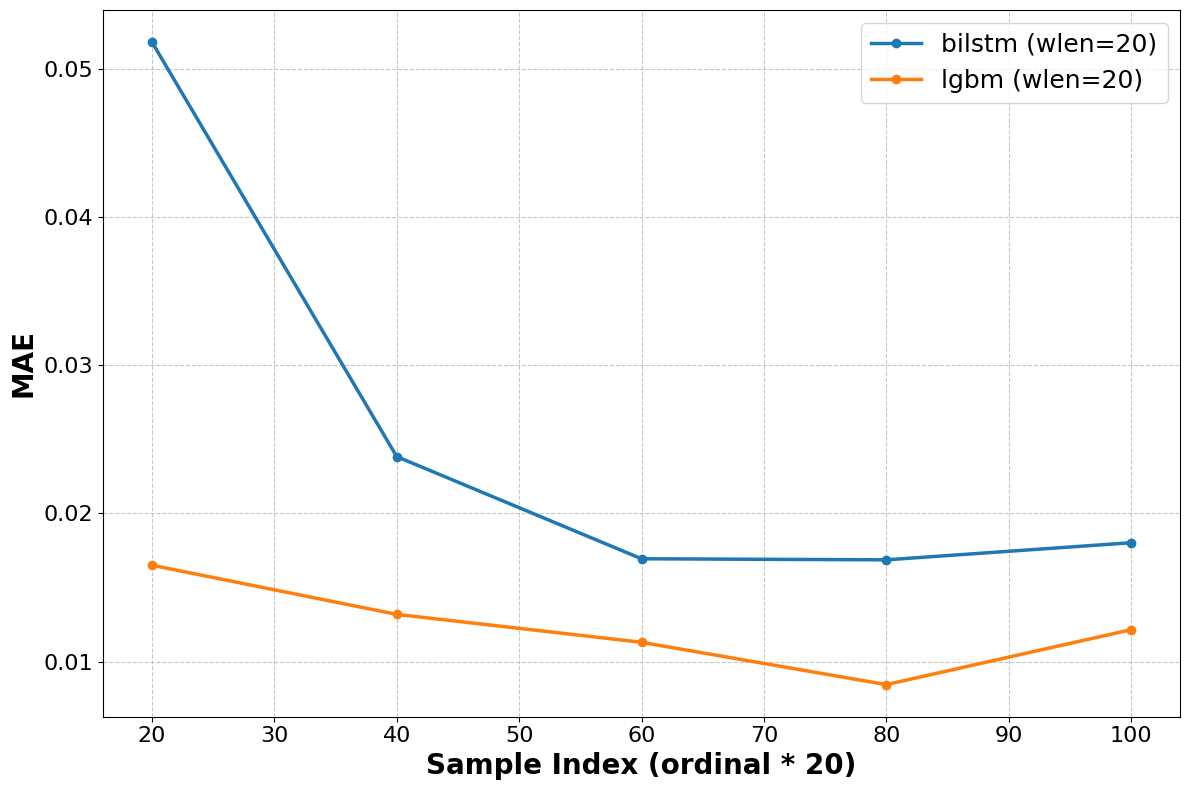

In [124]:
# 4) plot
plt.figure(figsize=(12, 8))

results = pd.DataFrame(results)

for model_name in results["model"].unique():
    # Subset for each model
    subset = results[results["model"] == model_name]
    # For X, you can multiply ordinal by 20 to reflect the sample index in the series
    xvals = subset["i-th window"] * test_wlen
    yvals = subset["MAE"]
    plt.plot(
        xvals[:5], 
        yvals[:5],
        marker="o",
        linestyle="-",
        label=f"{model_name} (wlen=20)",
        linewidth=2.5  # Thicker line for better visibility
    )

# Axis labels
plt.xlabel("Sample Index (ordinal * 20)", fontsize=20, fontweight='bold')
plt.ylabel("MAE", fontsize=20, fontweight='bold')

# Grid and legend
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=18, loc='upper right')

# Tick parameters
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Save the figure in high resolution for publication
plt.tight_layout()
plt.savefig("MAE_comparison_plot.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()